In [1]:
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

import torch_geometric
import itertools
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv, GATv2Conv
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax, get_laplacian, to_dense_adj
from my_gat import my_GATConv
from my_mlp_gat import GATv3Layer
sys.path.insert(0, os.path.abspath('../../'))
from torch_geometric.datasets import Planetoid

import torch.nn.functional as F # <-- Remove

# Data function

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
datasets = [Planetoid(root='data/CiteSeer/', name='CiteSeer'), Planetoid(root='data/Cora/', name='Cora'),Planetoid(root='data/PubMed/', name='PubMed')]

# Setup models

In [4]:
# class Eigen(nn.Module):
#     def __init__(self, k):
#         super().__init__()
#         self.k = k
    
#     def forward(self, edge_idx):
#         lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
#         lap_adj = to_dense_adj(lap_idx)
#         eigenvals, eigenvecs = torch.linalg.eig(lap_adj)
#         top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
#         top_eig = torch.real(top_eig)
#         new_edge_features = torch.Tensor(edge_idx.size(1), 2 * self.k).to(edge_idx.device)
#         new_edge_idx = edge_idx.T

#         for idx, pair in enumerate(new_edge_idx):
#             i, j = pair
#             x_i_prime = top_eig[i]
#             x_j_prime = top_eig[j]
#             new_feat = torch.cat([x_i_prime, x_j_prime], dim=0)
#             new_edge_features[idx] = new_feat

#         return new_edge_features
    
def get_graph_stats(edge_idx, y):
    new_edge_idx = edge_idx.T
    total_edges = new_edge_idx.size(0)
    p = 0
    q = 0
    for idx, pair in enumerate(new_edge_idx):
        i, j = pair
        if y[i] == y[j]:
            p += 1
        else:
            q += 1
    
    p = p/total_edges
    q = q/total_edges
        
    return p, q    

class Model_GAT(torch.nn.Module):
    def __init__(self, d, out_d, K):
        super(Model_GAT, self).__init__()
        
        self.conv1 = my_GATConv(d, out_d, heads=K)
#         self.conv1 = GATv2Conv(d, out_d, heads=K, concat=False, share_weights=True)
#         self.conv1 = my_MLP_GATConv(d, out_d, 2, 100, share_weights=True)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x, attn_weights, pair_pred = self.conv1(x, data.edge_index, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred
    
class Model_GCN(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GCN, self).__init__()
        
        self.conv1 = GCNConv(d,out_d, bias=False)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x = self.conv1(x, data.edge_index)
        
        return x.squeeze(-1)
    
class Model_linear(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_linear, self).__init__()
        
        self.linear = torch.nn.Linear(d,out_d, bias=False)

    def forward(self, data):
        
        # 1. Obtain node embeddings 
        x = data.x
        x = self.linear(x)
        
        return x.squeeze(-1)

In [5]:
class Eigen2(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
        
    def forward(self, edge_idx, n, sigma):
        lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
        lap_adj = to_dense_adj(lap_idx)
        eigenvals, eigenvecs = torch.linalg.eig(lap_adj)
        top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
        top_eig = torch.real(top_eig)
        
        new_edge_features = torch.Tensor(edge_idx.size(1), 1).to(edge_idx.device)
        new_edge_idx = edge_idx.T
        
        for idx, pair in enumerate(new_edge_idx):
            i, j = pair
            x_i_prime = top_eig[i]
            x_j_prime = top_eig[j]
            dot = torch.dot(x_i_prime, x_j_prime)
            final = 8 * torch.sqrt(torch.log(torch.tensor(n))) * sigma * torch.sign(dot)
            new_edge_features[idx] = final
            
        return new_edge_features.view(-1, 1)

class Model_GATv3(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GATv3, self).__init__()
        
        self.eigen = Eigen2(1)
        self.conv1 = GATv3Layer(
            in_channels=d, 
            out_channels=out_d,
            att_in_channels=2,
            att_out_channels=4,
            share_weights=True, 
            bias=False
        )

    def forward(self, data, mu):
        x = data.x
        # e = data.edge_index
        # y = data.y
        n = x.size(0)

        # p, q = get_graph_stats(e, y)
        sigma = torch.std(x)

        eigen_x = self.eigen(data.edge_index, n=n, sigma=sigma)
        x, attn_weights, pair_pred = self.conv1(x, data.edge_index, edge_attr=eigen_x, cur_mu=mu, sigma=sigma, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred

## Setup train and accuracy functions

In [6]:
@torch.no_grad()
def measure_accuracy(model, data):
    model.eval()
         
    logits = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc

## Setup MLP GAT and GAT

In [7]:
@torch.no_grad()
def measure_accuracy_gat(model, data, mu):
    model.eval()
         
    logits, attn_weights, pair_pred = model(data, mu) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc, attn_weights, pair_pred

## Utility functions

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def info_mlp_gat(attn_weights, idx, head):
    intra_weight = []
    idx_intra = []
    inter_weight = []
    idx_inter = []

    weights = attn_weights[1] # get gamma values

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)) or ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight.append(weights[i].item())
            idx_intra.append(i)
        else:
            inter_weight.append(weights[i].item())
            idx_inter.append(i)
    return intra_weight, idx_intra, inter_weight, idx_inter

def info_mlp_gat_scores_phi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[2] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def info_mlp_gat_scores_psi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[3] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def my_plot_violin(intra_weight, inter_weight):
    plt.figure(figsize=(10, 6), dpi=80)
    ww_intra = np.ones_like(intra_weight)/len(intra_weight)
    ww_inter = np.ones_like(inter_weight)/len(inter_weight)
#     plt.hist(intra_weight, bins=500, weights=ww_intra, alpha=0.9, label='Intra')
#     plt.hist(inter_weight, bins=500, weights=ww_inter, alpha=0.6, label='Inter')
    pos = [1, 1.5]
    plt.violinplot([intra_weight, inter_weight], pos, points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=False)
    plt.legend(loc='upper right')
    plt.yscale('linear')
    plt.show()
    
def pair_acc(n_edges, pair_pred, idx_intra, idx_inter, head):
    
    tmp = torch.zeros(n_edges).to(device)
    tmp[pair_pred[:,head].reshape(len(pair_pred)) > 0] = 1

    gt = torch.zeros(n_edges).to(device)
    gt[idx_intra] = 1

    acc_intra_edges = 1 - torch.sum(torch.abs(gt[idx_intra] - tmp[idx_intra]))/len(idx_intra)
    acc_inter_edges = 1 - torch.sum(torch.abs(gt[idx_inter] - tmp[idx_inter]))/len(idx_inter)
    print("Head: ", head, " acc intra edges: ", acc_intra_edges.item(), " acc inter edges: ", acc_inter_edges.item())
    
    return acc_intra_edges, acc_inter_edges

In [12]:
def my_plot(name, which_class, heads, mus, degree, intra_gamma, inter_gamma, intra_gamma_, inter_gamma_, 
            intra_gamma_std, inter_gamma_std, intra_gamma_std_, inter_gamma_std_, 
            test_acc_mlp_gat, test_acc_gat, test_acc_gcn, test_acc_lin, 
            acc_intra_edges_all, acc_inter_edges_all, acc_intra_edges_all_, acc_inter_edges_all_,
            phi_intra_attn_00, phi_intra_attn_11, phi_inter_attn_01, phi_inter_attn_10,
            phi_intra_attn_00_std, phi_intra_attn_11_std, phi_inter_attn_01_std, phi_inter_attn_10_std,
            psi_intra_attn_00, psi_intra_attn_11, psi_inter_attn_01, psi_inter_attn_10,
            psi_intra_attn_00_std, psi_intra_attn_11_std, psi_inter_attn_01_std, psi_inter_attn_10_std):
    
    mus = mus.cpu()
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(intra_gamma)-np.asarray(intra_gamma_std),np.asarray(intra_gamma)+np.asarray(intra_gamma_std),alpha=0.4)

    plt.plot(mus,inter_gamma, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(inter_gamma)-np.asarray(inter_gamma_std),np.asarray(inter_gamma)+np.asarray(inter_gamma_std),alpha=0.4)
    
    d_mean = (1+degree).mean().cpu()
#     inv_d_std = (1/(1+degree)).std().cpu()
    inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_degree_mean_vec, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')
#     plt.fill_between(mus,inv_degree_mean_vec-inv_d_std,inv_degree_mean_vec+inv_d_std,alpha=0.4)

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/gammas_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma_std, linewidth=2, linestyle='-', marker='*', markersize=9, label='Stand. dev. $\gamma$, intra edges, MLP-GAT')

    plt.plot(mus,inter_gamma_std, linewidth=2, linestyle='-', marker='X', markersize=9, label='Stand. dev. $\gamma$, inter edges, MLP-GAT')
    
#     d_mean = (1+degree).mean().cpu()
    inv_d_std = (1/(1+degree)).std().cpu()
#     inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_d_std*np.ones(len(mus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Stand. dev. of $1/|N_i|$')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/gammas_std_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

    marker_intra = ['v','^','>','<']
    marker_inter = ['1','2','3','4']
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,test_acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT')
    plt.plot(mus,test_acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9, label='GCN')
    plt.plot(mus,test_acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/node_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,acc_intra_edges_all, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT, intra edge classification')
    plt.plot(mus,acc_inter_edges_all, linewidth=2, linestyle='-', marker='X', markersize=9, label='MLP-GAT, inter edge classification')
    
#     for head in range(heads):
#         plt.plot(mus,acc_intra_edges_all_[head], linewidth=2, linestyle='-', marker=marker_intra[head], markersize=9, label='GAT, intra edge classification'+' head '+str(head))
#         plt.plot(mus,acc_inter_edges_all_[head], linewidth=2, linestyle='-', marker=marker_inter[head], markersize=9, label='GAT, inter edge classification'+' head '+str(head))       

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/edge_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------PSI---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)
    
    plt.plot(mus, psi_intra_attn_00, label="$C_0=0, C_1=0$", linewidth=2, linestyle="-", markersize=9, marker="*")
    plt.fill_between(mus, np.asarray(psi_intra_attn_00)-np.asarray(psi_intra_attn_00_std), np.asarray(psi_intra_attn_00)+np.asarray(psi_intra_attn_00_std), alpha=0.4)
    
    plt.plot(mus, psi_intra_attn_11, label="$C_0=1, C_1=1$", linewidth=2, linestyle="-", markersize=9, marker="X")
    plt.fill_between(mus, np.asarray(psi_intra_attn_11)-np.asarray(psi_intra_attn_11_std), np.asarray(psi_intra_attn_11)+np.asarray(psi_intra_attn_11_std), alpha=0.4)
    
    plt.plot(mus, psi_inter_attn_10, label="$C_0=1, C_1=0$", linewidth=2, linestyle="-", markersize=9, marker="+")
    plt.fill_between(mus, np.asarray(psi_inter_attn_10)-np.asarray(psi_inter_attn_10_std), np.asarray(psi_inter_attn_10)+np.asarray(psi_inter_attn_10_std), alpha=0.4)
    
    plt.plot(mus, psi_inter_attn_01, label="$C_0=0, C_1=1$", linewidth=2, linestyle="-", markersize=9, marker="o")
    plt.fill_between(mus, np.asarray(psi_inter_attn_01)-np.asarray(psi_inter_attn_01_std), np.asarray(psi_inter_attn_01)+np.asarray(psi_inter_attn_01_std), alpha=0.4)
    
    plt.grid(linestyle="dashed")
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\Psi$ Values', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/psi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------PHI---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)
    
    plt.plot(mus, phi_intra_attn_00, label="$C_0=0, C_1=0$", linewidth=2, linestyle="-", markersize=9, marker="*")
    plt.fill_between(mus, np.asarray(phi_intra_attn_00)-np.asarray(phi_intra_attn_00_std), np.asarray(phi_intra_attn_00)+np.asarray(phi_intra_attn_00_std), alpha=0.4)
    
    plt.plot(mus, phi_intra_attn_11, label="$C_0=1, C_1=1$", linewidth=2, linestyle="-", markersize=9, marker="X")
    plt.fill_between(mus, np.asarray(phi_intra_attn_11)-np.asarray(phi_intra_attn_11_std), np.asarray(phi_intra_attn_11)+np.asarray(phi_intra_attn_11_std), alpha=0.4)
    
    plt.plot(mus, phi_inter_attn_10, label="$C_0=1, C_1=0$", linewidth=2, linestyle="-", markersize=9, marker="+")
    plt.fill_between(mus, np.asarray(phi_inter_attn_10)-np.asarray(phi_inter_attn_10_std), np.asarray(phi_inter_attn_10)+np.asarray(phi_inter_attn_10_std), alpha=0.4)
    
    # plt.plot(mus, phi_inter_attn_01, label="$C_0=0, C_1=1$", linewidth=2, linestyle="-", markersize=9, marker="o")
    # plt.fill_between(mus, np.asarray(phi_inter_attn_01)-np.asarray(phi_inter_attn_01_std), np.asarray(phi_inter_attn_01)+np.asarray(phi_inter_attn_01_std), alpha=0.4)
    
    plt.grid(linestyle="dashed")
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\Phi$ Values', fontsize=20)
    plt.show()
    
    fig.savefig("figures3/phi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')

## Ansatz 

In [13]:
def create_ansatz_mlp_gat(model, mean, R):
    
    model_mlp_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_mlp_gat_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_mlp_gat_ansatz.conv1.att_in.weight = torch.nn.Parameter(torch.tensor([[1.0,1.0],[-1.0,-1.0],[1.0,-1.0],[-1.0,1.0]])) # S
        model_mlp_gat_ansatz.conv1.att_out.weight = torch.nn.Parameter(torch.tensor([[1.0, 1.0, -1.0, -1.0]])) # r

    model_mlp_gat_ansatz.to(device)

    return model_mlp_gat_ansatz

def create_ansatz_gat(model, mean, R):
    
    model_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    alpha_src = R/torch.sqrt(torch.tensor(2.0))
    alpha_dst = -alpha_src
    bias_lin = torch.tensor([0.0])
    bias_att = -torch.dot(w,mean)*alpha_src
#     bias_att = torch.tensor([1000.0])
    
    with torch.no_grad():
        model_gat_ansatz.conv1.lin.weight[0] = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_gat_ansatz.conv1.lin.weight[1] = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_gat_ansatz.conv1.lin.bias[0] = torch.nn.Parameter(bias_lin)
        model_gat_ansatz.conv1.lin.bias[1] = torch.nn.Parameter(bias_lin)
        model_gat_ansatz.conv1.att_src[0][0] = torch.nn.Parameter(alpha_src)
        model_gat_ansatz.conv1.att_src[0][1] = torch.nn.Parameter(alpha_dst)
        model_gat_ansatz.conv1.att_dst[0][0] = torch.nn.Parameter(alpha_src)
        model_gat_ansatz.conv1.att_dst[0][1] = torch.nn.Parameter(alpha_dst)
        model_gat_ansatz.conv1.bias_att[0] = torch.nn.Parameter(bias_att)
        model_gat_ansatz.conv1.bias_att[1] = torch.nn.Parameter(-bias_att)

    model_gat_ansatz.to(device)

    return model_gat_ansatz

def create_ansatz_gcn(model, mean, R):
    
    model_gcn_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_gcn_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_gcn_ansatz.to(device)

    return model_gcn_ansatz

def create_ansatz_linear(model, mean, R):
    
    model_linear_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_linear_ansatz.linear.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_linear_ansatz.to(device)

    return model_linear_ansatz

## Run experiments

CiteSeer
Number of classes:  tensor(6)
torch.Size([2, 9104]) torch.Size([3327, 3703])
Class:  0
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN		Train: 0.6833 | Test: 0.7300
Linear		Train: 0.7667 | Test: 0.7990
with indicator tensor(9.9984e-05, dtype=torch.float64) tensor(0.0953)
MLP GAT ansatz		Train: 0.6917 | Test: 0.7390
Head:  0  acc intra edges:  0.2830284833908081  acc inter edges:  1.0
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN		Train: 0.6833 | Test: 0.7310
Linear		Train: 0.7667 | Test: 0.7990
with indicator tensor(0.0001, dtype=torch.float64) tensor(0.0953)
MLP GAT ansatz		Train: 0.6917 | Test: 0.7390
Head:  0  acc intra edges:  0.2830284833908081  acc inter edges:  1.0
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN		Train: 0.6833 | Test: 0.7310
Linear		Train: 0.7667 | Test: 0.7990
with indicator tensor(0.0002, dtype=torch.float64) tensor(0.0953)
MLP GAT ansatz		Train: 0.6917 | Test: 0.7410
Head:  0  acc intra edges:  0.2830284833908081  acc inter edges:  1.0


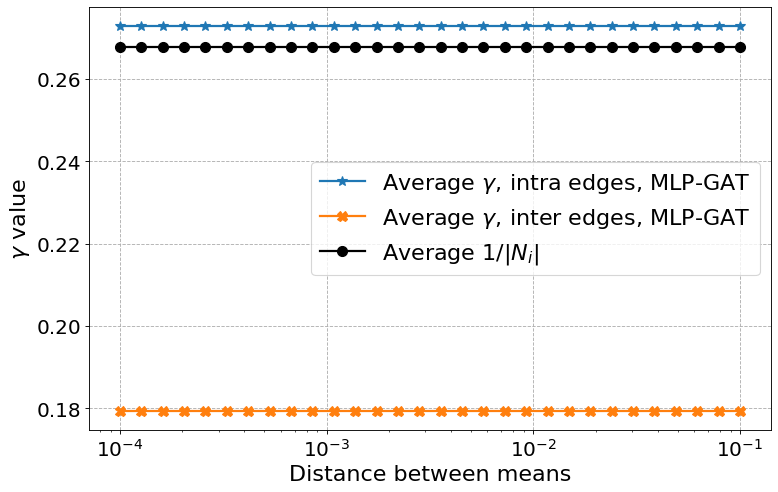

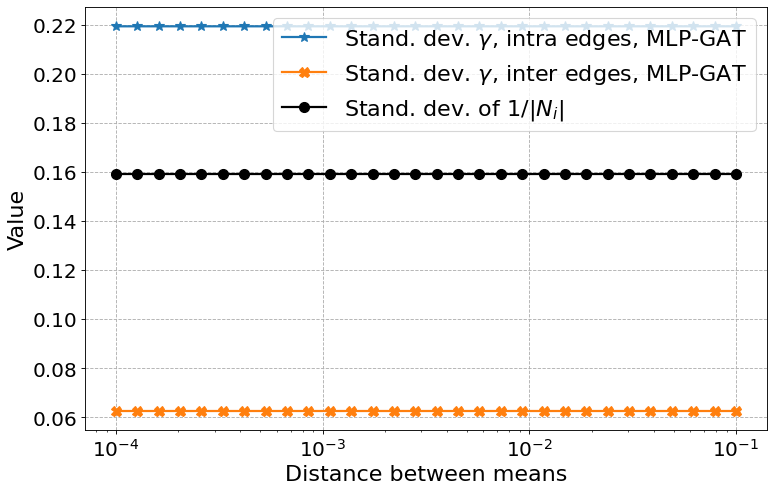

<Figure size 1280x960 with 0 Axes>

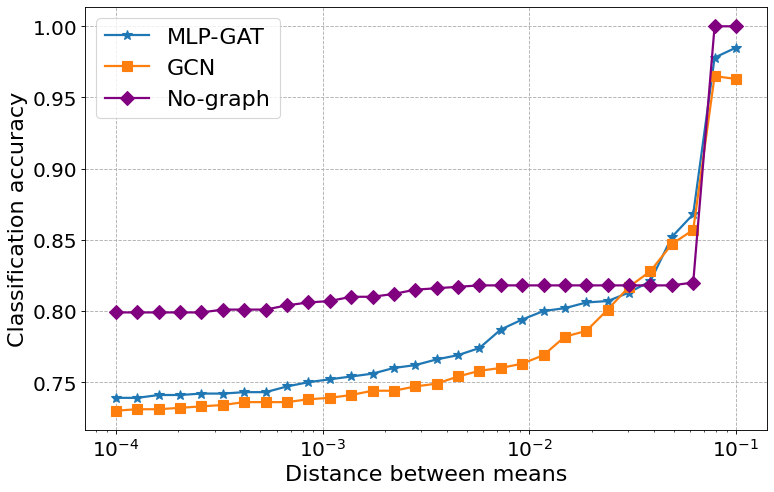

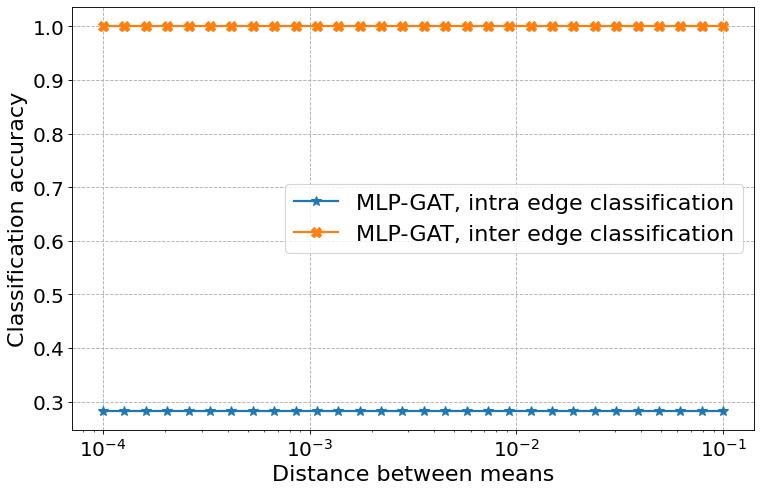

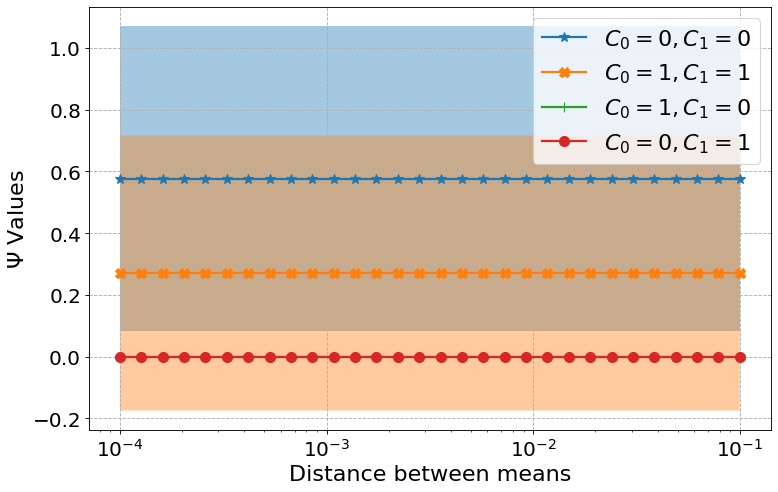

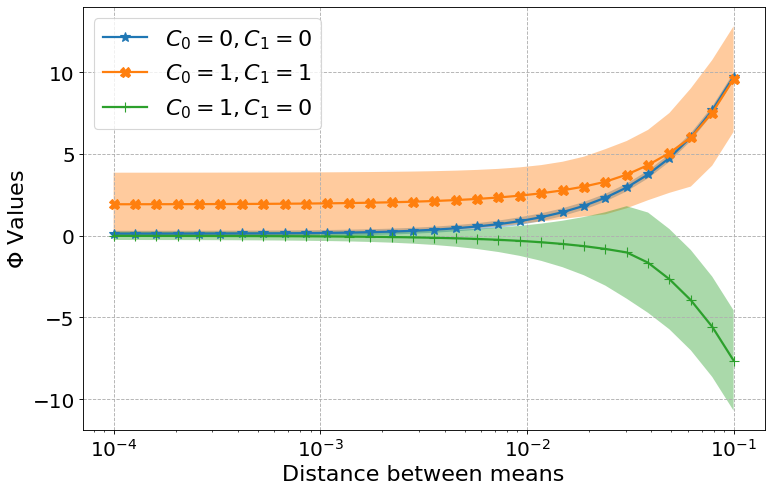

Class:  1
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN		Train: 0.6500 | Test: 0.6050
Linear		Train: 0.6333 | Test: 0.5810
with indicator tensor(0.0004, dtype=torch.float64) tensor(0.0901)
MLP GAT ansatz		Train: 0.6417 | Test: 0.6080
Head:  0  acc intra edges:  0.291867733001709  acc inter edges:  1.0
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN		Train: 0.6750 | Test: 0.6400
Linear		Train: 0.6417 | Test: 0.5940
with indicator tensor(0.0005, dtype=torch.float64) tensor(0.0901)
MLP GAT ansatz		Train: 0.6500 | Test: 0.6410
Head:  0  acc intra edges:  0.291867733001709  acc inter edges:  1.0
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN		Train: 0.6917 | Test: 0.6840
Linear		Train: 0.6750 | Test: 0.6500
with indicator tensor(0.0007, dtype=torch.float64) tensor(0.0901)
MLP GAT ansatz		Train: 0.6833 | Test: 0.6740
Head:  0  acc intra edges:  0.291867733001709  acc inter edges:  1.0
mu/max(mus) tensor(0.0020, dtype=torch.float64)
GCN		Train: 0.7250 | Test: 0.7260
Linear		Tra

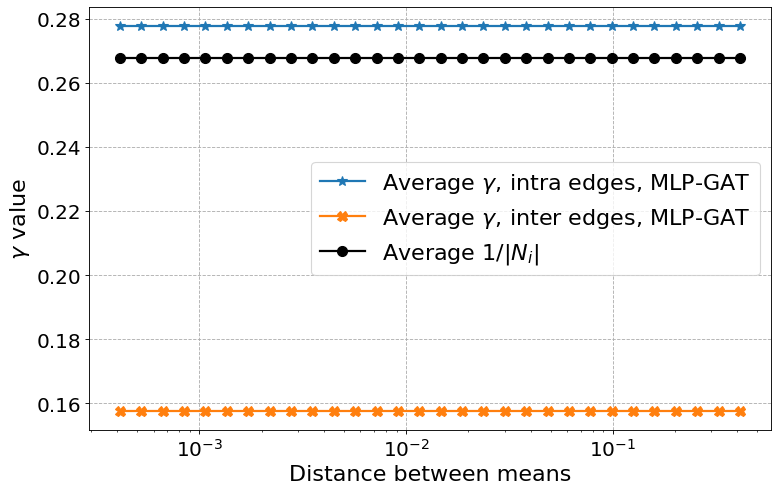

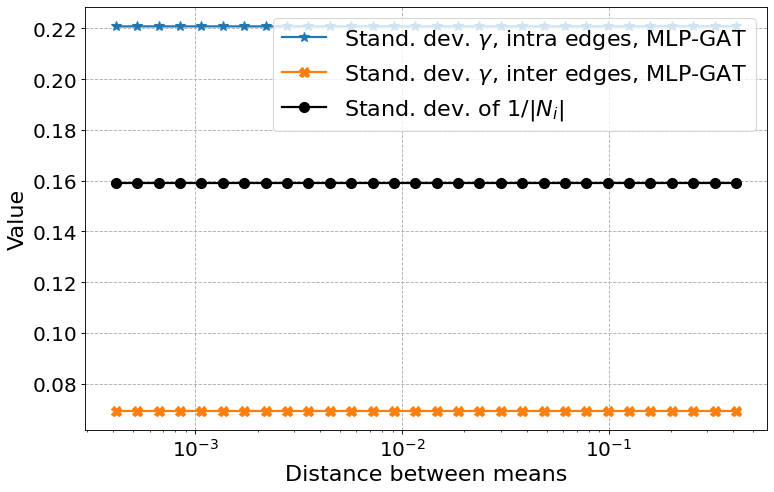

<Figure size 1280x960 with 0 Axes>

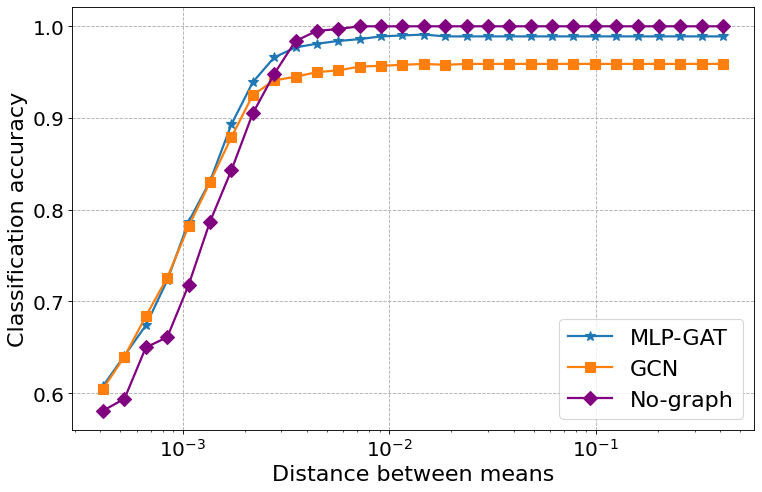

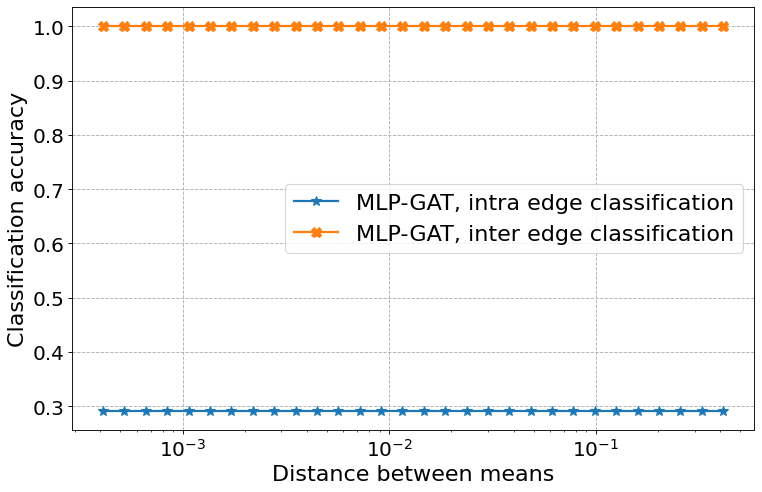

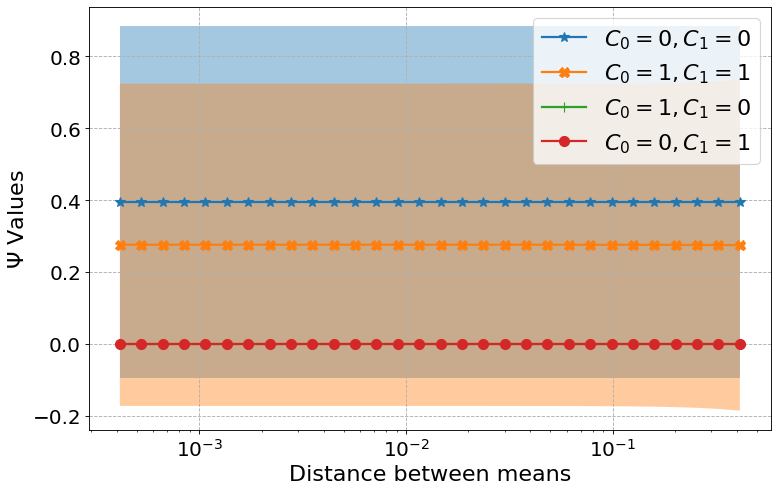

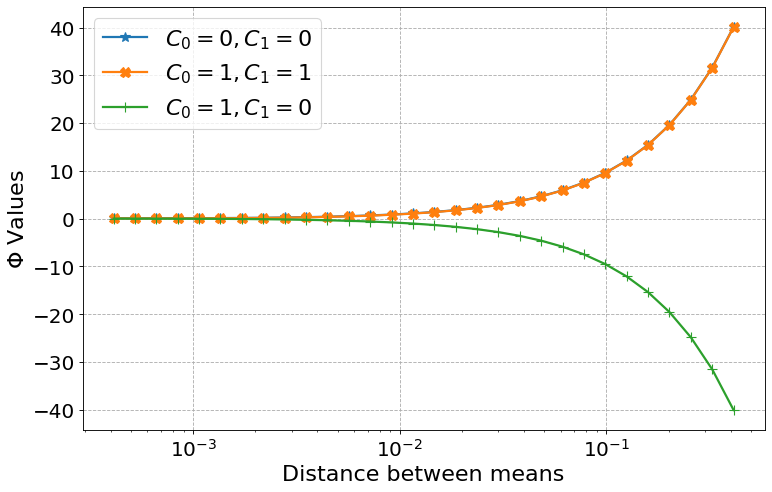

Class:  2
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN		Train: 0.6500 | Test: 0.6780
Linear		Train: 0.7250 | Test: 0.7270
with indicator tensor(0.0001, dtype=torch.float64) tensor(0.0951)
MLP GAT ansatz		Train: 0.6583 | Test: 0.6930
Head:  0  acc intra edges:  0.2949206829071045  acc inter edges:  1.0
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN		Train: 0.6583 | Test: 0.6800
Linear		Train: 0.7500 | Test: 0.7400
with indicator tensor(0.0001, dtype=torch.float64) tensor(0.0951)
MLP GAT ansatz		Train: 0.6583 | Test: 0.6950
Head:  0  acc intra edges:  0.2949206829071045  acc inter edges:  1.0
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN		Train: 0.6583 | Test: 0.6820
Linear		Train: 0.7500 | Test: 0.7400
with indicator tensor(0.0002, dtype=torch.float64) tensor(0.0951)
MLP GAT ansatz		Train: 0.6583 | Test: 0.6950
Head:  0  acc intra edges:  0.2949206829071045  acc inter edges:  1.0
mu/max(mus) tensor(0.0020, dtype=torch.float64)
GCN		Train: 0.6583 | Test: 0.6830
Linear		

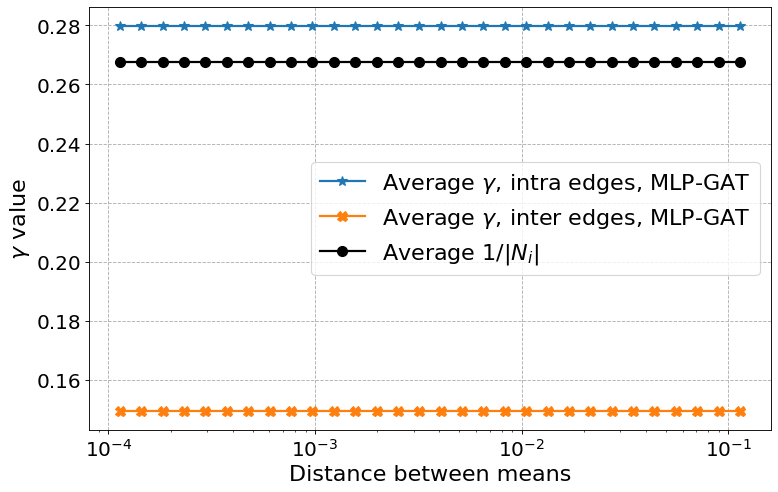

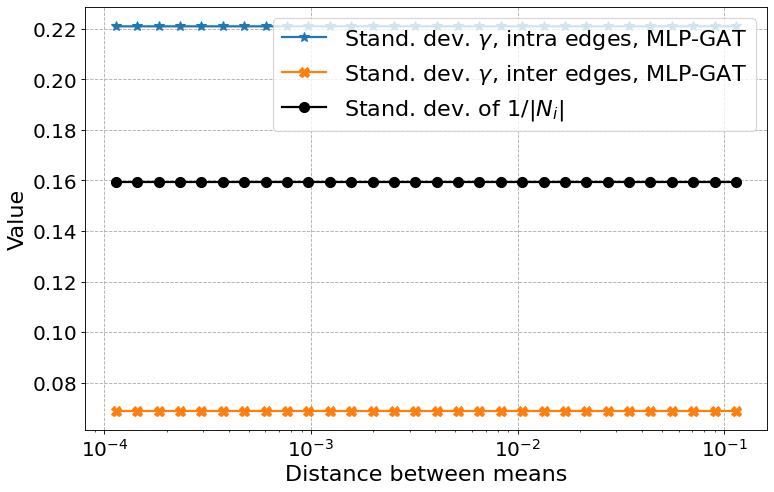

<Figure size 1280x960 with 0 Axes>

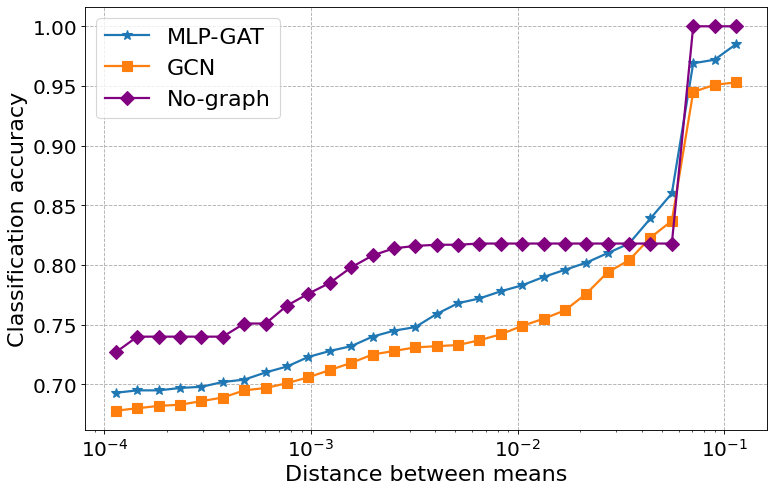

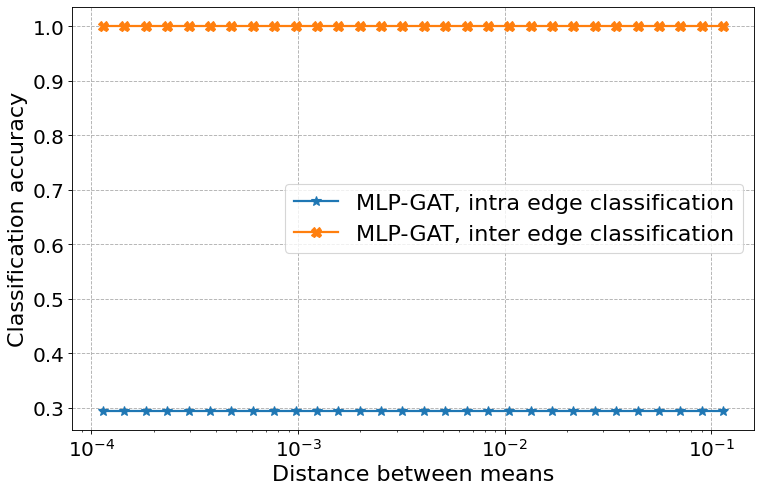

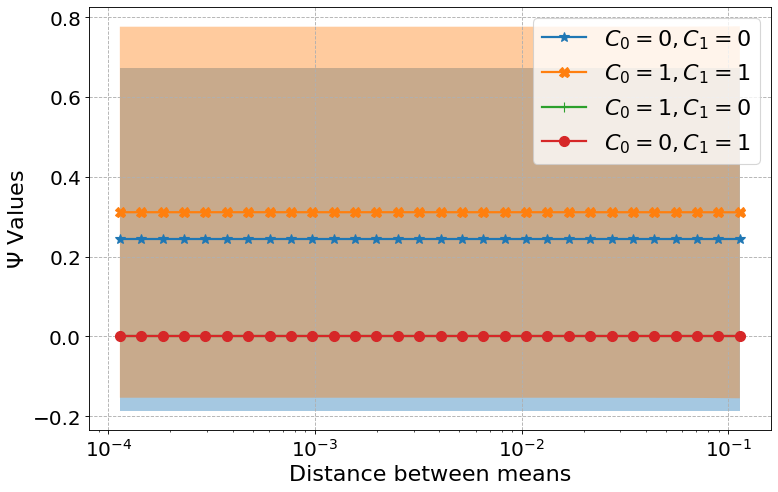

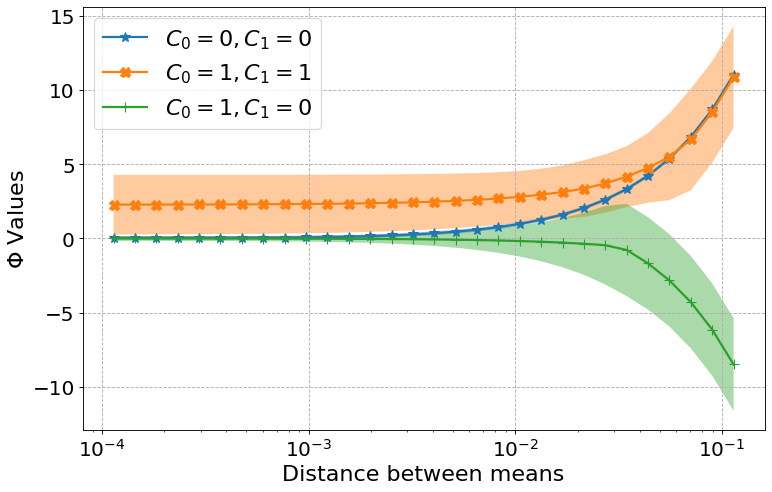

Class:  3
mu/max(mus) tensor(0.0010, dtype=torch.float64)
GCN		Train: 0.6000 | Test: 0.6340
Linear		Train: 0.7583 | Test: 0.7160
with indicator tensor(0.0001, dtype=torch.float64) tensor(0.0950)
MLP GAT ansatz		Train: 0.6583 | Test: 0.6500
Head:  0  acc intra edges:  0.28560394048690796  acc inter edges:  1.0
mu/max(mus) tensor(0.0013, dtype=torch.float64)
GCN		Train: 0.6000 | Test: 0.6360
Linear		Train: 0.7583 | Test: 0.7160
with indicator tensor(0.0001, dtype=torch.float64) tensor(0.0950)
MLP GAT ansatz		Train: 0.6667 | Test: 0.6530
Head:  0  acc intra edges:  0.28560394048690796  acc inter edges:  1.0
mu/max(mus) tensor(0.0016, dtype=torch.float64)
GCN		Train: 0.6083 | Test: 0.6380
Linear		Train: 0.7583 | Test: 0.7160
with indicator tensor(0.0002, dtype=torch.float64) tensor(0.0950)
MLP GAT ansatz		Train: 0.6667 | Test: 0.6560
Head:  0  acc intra edges:  0.28560394048690796  acc inter edges:  1.0
mu/max(mus) tensor(0.0020, dtype=torch.float64)
GCN		Train: 0.6167 | Test: 0.6390
Linea

KeyboardInterrupt: 

In [14]:
for dataset in datasets:
    print(dataset.name)
    data = dataset[0].to(device)
    n_classes = data.y.max() + 1
    print("Number of classes: ", n_classes)
    n = data.y.shape[0]
    data.x_backup = copy.deepcopy(data.x) 
    degree = torch_geometric.utils.degree(data.edge_index[1], n)
    
    print (data.edge_index.shape, data.x.shape)
    
    for which_class in range(n_classes):
        print("Class: ", which_class)
        y = torch.zeros(n, dtype=torch.float64).to(device)
        idx = data.y == which_class
        y[idx] = 1
        data.ynew = y
        
        mean0 = data.x_backup[idx].mean(dim=0)
        mean1 = data.x_backup[~idx].mean(dim=0)
        
        distance = torch.norm(mean0-mean1)
        mu = distance/(2*torch.sqrt(torch.tensor(data.x.shape[1])))
        
        mu_up = 10*mu
        mu_lb = 0.01*mu

        mus = torch.tensor(np.geomspace(mu_lb.item(), mu_up.item(), 30, endpoint=True)).to(device)
        
        test_acc_mlp_gat = []
        test_acc_gat = []
        test_acc_gcn = []
        test_acc_lin = []
        intra_gamma = []
        inter_gamma = []
        intra_gamma_std = []
        inter_gamma_std = []
        acc_intra_edges_all = []
        acc_inter_edges_all = []
        intra_gamma_ = []
        inter_gamma_ = []
        intra_gamma_std_ = []
        inter_gamma_std_ = []
        acc_intra_edges_all_ = []
        acc_inter_edges_all_ = []
        
        phi_intra_attn_00 = []
        phi_intra_attn_11 = []        
        phi_inter_attn_01 = []
        phi_inter_attn_10 = []
        
        phi_intra_attn_00_std = []
        phi_intra_attn_11_std = []        
        phi_inter_attn_01_std = []
        phi_inter_attn_10_std = []
        
        psi_intra_attn_00 = []
        psi_intra_attn_11 = []        
        psi_inter_attn_01 = []
        psi_inter_attn_10 = []
        
        psi_intra_attn_00_std = []
        psi_intra_attn_11_std = []        
        psi_inter_attn_01_std = []
        psi_inter_attn_10_std = []
        
        heads = 2
        for head in range(heads):
            intra_gamma_.append([[],[]])
            inter_gamma_.append([[],[]])
            intra_gamma_std_.append([[],[]])
            inter_gamma_std_.append([[],[]])
            acc_intra_edges_all_.append([])
            acc_inter_edges_all_.append([])
            
        for mu_ in mus:
            
            print("mu/max(mus)", mu_/max(mus))
        
            new_mean0 = mu_*torch.ones(data.x.shape[1]).to(device)
            new_mean1 = -mu_*torch.ones(data.x.shape[1]).to(device)

            data.x[idx] = data.x_backup[idx] - mean0 + new_mean0
            data.x[~idx] = data.x_backup[~idx] - mean1 + new_mean1

            model_gcn_ansatz = create_ansatz_gcn(Model_GCN(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_gcn_ansatz, data)
            print(f"GCN\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_gcn.append(test_acc)

            model_linear_ansatz = create_ansatz_linear(Model_linear(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_linear_ansatz, data)
            print(f"Linear\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_lin.append(test_acc)
            
            model_gatv3_ansatz = create_ansatz_mlp_gat(Model_GATv3(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc, attn_weights, pair_pred = measure_accuracy_gat(model_gatv3_ansatz, data, mu_)
            print(f"MLP GAT ansatz\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_mlp_gat.append(test_acc)
            
            intra_weight, idx_intra, inter_weight, idx_inter = info_mlp_gat(attn_weights, idx, 0)
            
            intra_gamma.append(np.asarray(intra_weight).mean())
            inter_gamma.append(np.asarray(inter_weight).mean())
            intra_gamma_std.append(np.asarray(intra_weight).std())
            inter_gamma_std.append(np.asarray(inter_weight).std())
            acc_intra_edges, acc_inter_edges = pair_acc(attn_weights[0][0].shape[0], pair_pred, idx_intra, idx_inter, 0)
            acc_intra_edges_all.append(acc_intra_edges.cpu())
            acc_inter_edges_all.append(acc_inter_edges.cpu())
            
            phi_intra_weight_00, phi_intra_weight_11, phi_idx_intra_scores, phi_inter_weight_01, phi_inter_weight_10, phi_idx_inter_scores = info_mlp_gat_scores_phi(attn_weights, idx, 0) # analyse phi scores
            psi_intra_weight_00, psi_intra_weight_11, psi_idx_intra_scores, psi_inter_weight_01, psi_inter_weight_10, psi_idx_inter_scores = info_mlp_gat_scores_psi(attn_weights, idx, 0) # analyse psi scores
            
            phi_intra_attn_00.append(np.asarray(phi_intra_weight_00).mean())
            phi_intra_attn_11.append(np.asarray(phi_intra_weight_11).mean())
            phi_inter_attn_01.append(np.asarray(phi_inter_weight_01).mean())
            phi_inter_attn_10.append(np.asarray(phi_inter_weight_10).mean())
            
            phi_intra_attn_00_std.append(np.asarray(phi_intra_weight_00).std())
            phi_intra_attn_11_std.append(np.asarray(phi_intra_weight_11).std())
            phi_inter_attn_01_std.append(np.asarray(phi_inter_weight_01).std())
            phi_inter_attn_10_std.append(np.asarray(phi_inter_weight_10).std())
            
            psi_intra_attn_00.append(np.asarray(psi_intra_weight_00).mean())
            psi_intra_attn_11.append(np.asarray(psi_intra_weight_11).mean())
            psi_inter_attn_01.append(np.asarray(psi_inter_weight_01).mean())
            psi_inter_attn_10.append(np.asarray(psi_inter_weight_10).mean())
            
            psi_intra_attn_00_std.append(np.asarray(psi_intra_weight_00).std())
            psi_intra_attn_11_std.append(np.asarray(psi_intra_weight_11).std())
            psi_inter_attn_01_std.append(np.asarray(psi_inter_weight_01).std())
            psi_inter_attn_10_std.append(np.asarray(psi_inter_weight_10).std())
            
        my_plot(dataset.name, which_class, heads, mus, degree, intra_gamma, inter_gamma, intra_gamma_, inter_gamma_, 
                intra_gamma_std, inter_gamma_std, intra_gamma_std_, inter_gamma_std_, 
                test_acc_mlp_gat, test_acc_gat, test_acc_gcn, test_acc_lin, 
                acc_intra_edges_all, acc_inter_edges_all, acc_intra_edges_all_, acc_inter_edges_all_,
                phi_intra_attn_00, phi_intra_attn_11, phi_inter_attn_01, phi_inter_attn_10,
                phi_intra_attn_00_std, phi_intra_attn_11_std, phi_inter_attn_01_std, phi_inter_attn_10_std,
                psi_intra_attn_00, psi_intra_attn_11, psi_inter_attn_01, psi_inter_attn_10,
                psi_intra_attn_00_std, psi_intra_attn_11_std, psi_inter_attn_01_std, psi_inter_attn_10_std)

In [ ]:
print ("hello")